# Group Details

## Group Name: 12

### Student 1: Denise La Gordt Dillie

### Student 2: Andreea Maican

### Student 3: Sambhav Jain

# Loading Data and Preliminaries

In [65]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import os

In [66]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [67]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_array('/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(initial_state)
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
[[ 4.54673709 -5.27118739  5.07863417 -1.09690628 -3.66929964]
 [ 3.57509525  4.3270607  -0.08095022 -0.57868726 -2.95971243]
 [ 2.67733735 -5.15972108  5.35238208  2.42652043  1.45870728]
 [ 2.27455417 -6.79584511  2.29632123  0.30418238 -0.4065998 ]
 [ 2.38359341 -2.75861066  1.77940931 -0.07643627 -0.35954359]
 [ 4.28596268  0.34981219  4.8286224   1.35630962 -2.55760522]
 [ 3.03118516 -0.50562258 15.04631712 -0.94772523 14.98127867]
 [ 4.13530017  1.81342682  3.84375499 -0.6989711  -2.25092411]]
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [68]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time. 
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_array('data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array('data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


In [69]:
test_initial_state

array([[ 4.31455329, -4.99311363, -5.10150489,  2.2491171 , -1.82520359],
       [ 2.58525749, -4.92574075, -4.7534334 , -4.81897728, -3.07212095],
       [ 2.40449047,  2.23254187, -6.04595524, -0.67381217, -0.58798851],
       [ 2.28318603,  5.6605113 , -3.76376281, -0.41268251, -1.19812499],
       [ 4.09793595, -4.73678906, -3.94704856,  1.13634781,  4.98383634],
       [ 4.5579536 , -0.08848969,  5.42483477,  1.460317  , -0.21585929],
       [ 3.42356878, -4.91282501, -4.6779343 ,  0.94123905,  2.66425652],
       [ 3.59288181, -4.48225046, -4.548729  , -2.56573061, -2.39203918]])

# Data Handling and Preprocessing

In [70]:
def create_graph_data(initial_state, terminal_state):
    '''Takes a datapoint from task 1 data and returns a Data object ready to be used with
    Pytorch Geometric. Each node is an object and will store initial position and speed, each edge stores
    the distance between two objects and also their masses.'''
    initial_state = np.array(initial_state)
    terminal_state = np.array(terminal_state)

    n_bodies = initial_state.shape[0]
    num_features = initial_state.shape[1] - 1  # Exclude the mass from node features

    # Create node features tensor
    node_features = torch.tensor(initial_state[:, 1:], dtype=torch.float)  # Exclude the mass
    node_features = node_features.view(-1, num_features)  # Reshape to (num_nodes, num_features)

    # Create edge index tensor
    edge_index = torch.tensor([[i, j] for i in range(n_bodies) for j in range(n_bodies) if i != j], dtype=torch.long)
    edge_index = edge_index.t().contiguous()  # Reshape to (2, num_edges)

    # Create edge features tensor
    num_edges = edge_index.size(1)
    edge_features = torch.empty(num_edges, 3, dtype=torch.float)  # +3 for distance and masses
    # Populate edge features with distance and masses
    for k, (i, j) in enumerate(edge_index.t()):
        dx = node_features[i, 0] - node_features[j, 0]
        dy = node_features[i, 1] - node_features[j, 1]
        distance = torch.sqrt(dx ** 2 + dy ** 2)
        masses = torch.from_numpy(initial_state[[i, j], 0]).float()  # Convert to PyTorch tensor
        edge_features[k] = torch.cat((distance.view(1), masses), dim=0)

    # Create target tensor
    target = torch.tensor(terminal_state, dtype=torch.float).view(-1, 2)  # Reshape to (num_nodes, num_features + 1)

    # Create PyG Data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=target)

    return data

# Example usage
initial_state = [[1.0, 0.5, 0.3, 0.2, 0.1], [2.0, 0.1, 0.4, 0.3, 0.2], [0.5, 0.7, 0.8, 0.9, 1.0]]
terminal_state = [[0.3, 0.2], [0.4, 0.6], [0.8, 0.9]]

graph_data = create_graph_data(initial_state, terminal_state)

In [71]:
def create_dataloader(data_folder, task, shuffle, batch_size):
    data_list = [] # List to store the Data objects

    # Loop over all files in the folder
    for filename in os.listdir(data_folder):
        file_path = os.path.join(data_folder, filename)

        # Read the data from the file (modify this part based on your file format)
        states = load_array(file_path, task=task)
        initial_state, terminal_state = states

        # Create the Data object using create_graph_data function
        data = create_graph_data(initial_state, terminal_state)

        # Append the Data object to the list
        data_list.append(data)

    # Print the number of data samples
    print(f"Number of data samples in {data_folder}: {len(data_list)}")

    # Create a data loader
    dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=shuffle)

    return dataloader

# Specify the paths to your train and test data folders
data_folder_train = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/train'
data_folder_test = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/test'

# Define the batch size
batch_size = 50

# Create data loaders
dataloader_train = create_dataloader(data_folder_train, task='task 1', shuffle=True, batch_size=batch_size)
dataloader_test = create_dataloader(data_folder_test, task='task 1', shuffle=False, batch_size=batch_size)

Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/train: 900
Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/test: 100


# Model Implementation

In [117]:
class Node_to_emb(nn.Module):
    def __init__(self, node_feat_dim=4, node_emb_dim=64):
        super().__init__()
        self.emb_dim = node_emb_dim
        self.node_dim = node_feat_dim
        self.emb = nn.Linear(self.node_dim, self.emb_dim)

    def forward(self, nodes):
        assert nodes.size(-1) == self.node_dim, 'wrong input dimension of node features!'
        out = self.emb(nodes)
        return out

class MpLayer(torch.nn.Module):
    def __init__(self, hidden_dim, activation=nn.ReLU()):
        super(MpLayer, self).__init__()
        self.edge_network = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim),
            activation
        )
        self.node_network = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, input_to_layer):
        node_tensor, edge_idx_tensor = input_to_layer
        edge_messages_input = torch.cat([node_tensor[edge_idx_tensor[0, :]], node_tensor[edge_idx_tensor[1, :]]], dim=-1)  # shape (num_edges, 2*node_dim + edge_dim)
        edge_messages_output = self.edge_network(edge_messages_input)  # shape (num_edges, hidden_dim)

        # Aggregate the edge messages for each node the edge points to
        node_agg_messages = torch.zeros(node_tensor.size(0), node_tensor.size(1)).to(node_tensor.device)
        node_agg_messages = node_agg_messages.scatter_add_(
            dim=0, index=edge_idx_tensor[1].unsqueeze(-1).expand(-1, node_tensor.size(1)), src=edge_messages_output
        )

        # Put the aggregated messages through the node update network
        node_out = self.node_network(torch.cat([node_tensor, node_agg_messages], dim=-1))

        return node_out, edge_idx_tensor

class MpGNN(nn.Module):
    def __init__(self, node_feat_dim, hidden_dim, activation=nn.ReLU(), num_layers=5, num_classes=2):
        super(MpGNN, self).__init__()
        self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
        self.forward_net = nn.Sequential(*[MpLayer(hidden_dim, activation) for _ in range(num_layers)])
        self.to_pred = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.node_to_emb(x)
        input_model = (x, edge_index)
        output_model = self.forward_net(input_model)
        x, _ = output_model

        out = torch.zeros(batch.size(0), x.size(1)).to(x.device)
        idx_aggregate_graph = batch.unsqueeze(-1).expand(-1, x.size(1))

        out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x)  # aggregate all node embeddings per graph in the batch

        x = self.to_pred(out)
        return x

# Model Training

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


In [121]:
import time

model = MpGNN(node_feat_dim=4, hidden_dim=32, num_layers=5)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
loss_func = torch.nn.MSELoss()

def train():
    model.train()
    for data in dataloader_train:
        data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_func(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    correct = 0
    total = 0

    for data in loader:
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        target = data.y.argmax(dim=1)
        correct += int((pred == target).sum())
        total += len(target)

    return correct / total

train_accs = []
test_accs = []
epochs = 10
start = time.time()

for epoch in range(1, epochs + 1):
    train()
    with torch.no_grad():
        train_acc = test(dataloader_train)
        test_acc = test(dataloader_test)
    toc = time.time()
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}. Training time so far: {toc - start:.1f} s')
    train_accs.append(train_acc)
    test_accs.append(test_acc)

Epoch: 001, Train Acc: 0.5059, Test Acc: 0.4660. Training time so far: 0.2 s
Epoch: 002, Train Acc: 0.5037, Test Acc: 0.4506. Training time so far: 0.5 s
Epoch: 003, Train Acc: 0.5059, Test Acc: 0.4660. Training time so far: 0.7 s
Epoch: 004, Train Acc: 0.5059, Test Acc: 0.4660. Training time so far: 0.9 s
Epoch: 005, Train Acc: 0.5059, Test Acc: 0.4660. Training time so far: 1.1 s
Epoch: 006, Train Acc: 0.5044, Test Acc: 0.4506. Training time so far: 1.3 s
Epoch: 007, Train Acc: 0.4941, Test Acc: 0.5340. Training time so far: 1.5 s
Epoch: 008, Train Acc: 0.4968, Test Acc: 0.5494. Training time so far: 1.7 s
Epoch: 009, Train Acc: 0.4852, Test Acc: 0.5494. Training time so far: 1.9 s
Epoch: 010, Train Acc: 0.4941, Test Acc: 0.5340. Training time so far: 2.1 s


In [122]:
def plot_train(train_accs, test_accs):
    fig, ax = plt.subplots(figsize=(8,6))
    fnt=16
    ax.plot(train_accs, color='blue', label='Train')
    ax.plot(test_accs, color='red', linestyle='--', label='Test')
    ax.legend(fontsize=fnt)
    ax.tick_params(axis='both', labelsize=fnt)
    ax.set_xlabel('Epoch', fontsize=fnt)
    ax.set_ylabel('Accuracy', fontsize=fnt)

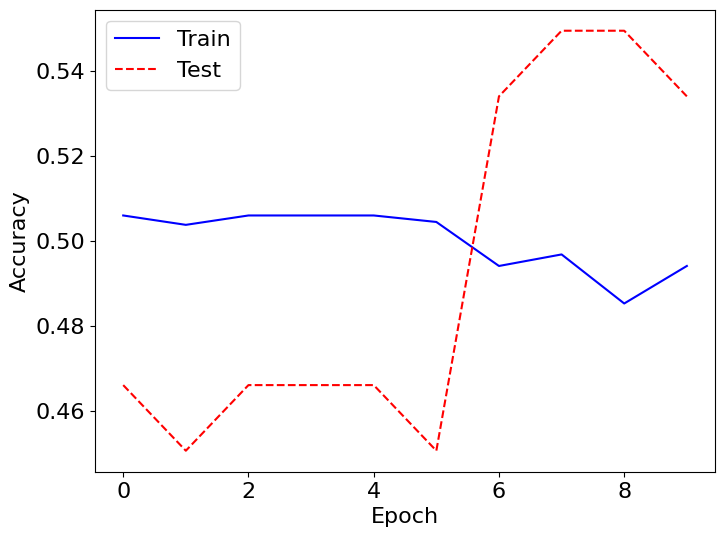

In [123]:
plot_train(train_accs, test_accs)

# Evaluation

In [124]:
print(f'Final Test accuracy: {test_accs[-1]}')

Final Test accuracy: 0.5339506172839507
